In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

In [7]:
batch = 32
h = 220
w = 220

# Parser

In [8]:
import csv

import lxml.html as html
import requests
import requests as req
import os

headers = {"User-Agent":
               "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36"
           }
base_url = "https://myanimelist.net"
target_url = "https://myanimelist.net/topanime.php"
first = True


def main():
    for i in range(85, 95):
        parse_anime(i)


def parse_anime(index):
    if index == 0:
        parse_initial()
    else:
        parse_list(index)


def parse_list(index):
    limit = index * 50
    page = req.get(target_url + f"?limit={limit}", headers=headers).text
    parsed_page = html.document_fromstring(page)
    anime_links = parsed_page.xpath("//a[@class='hoverinfo_trigger']/@href")
    for link in anime_links:
        parse_single_link(link)


def parse_initial():
    page = req.get(target_url, headers=headers).text
    parsed_page = html.document_fromstring(page)
    anime_links = parsed_page.xpath("//a[@class='hoverinfo_trigger']/@href")
    for link in anime_links:
        parse_single_link(link)


def parse_single_link(link):
    try:
        page = req.get(link, headers=headers).text
        parsed_page = html.document_fromstring(page)

        genre = parsed_page.xpath("//span[@itemprop='genre']/text()")[1].replace(" ", "_")
        if genre in ['Adventure', 'Drama', 'Comedy', 'Fantasy']:
            photo = parsed_page.xpath("//img[contains(@data-src, 'cdn.myanimelist.net/images/anime/')]/@data-src")[0]

            download_image_to_genre_directory(genre, photo)

    except Exception as err:
        print(err)
        return


def download_image_to_genre_directory(genre, url):
    try:
        genre_directory = os.path.join(os.getcwd(), genre)
        if not os.path.exists(genre_directory):
            os.makedirs(genre_directory)
            print(f"Created directory: {genre_directory}")

        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful

        image_name = os.path.basename(url)
        image_path = os.path.join(genre_directory, image_name)

        with open(image_path, 'wb') as file:
            file.write(response.content)

        print(f"Image downloaded successfully and saved at: {image_path}")

    except requests.exceptions.HTTPError as errh:
        print("HTTP Error:", errh)
    except requests.exceptions.ConnectionError as errc:
        print("Error Connecting:", errc)
    except requests.exceptions.Timeout as errt:
        print("Timeout Error:", errt)
    except requests.exceptions.RequestException as err:
        print("Error:", err)


if __name__ == '__main__':
    main()

Created directory: C:\D\ITMO\5 sem\AnDan\images-IlyaStepanov1104\Adventure
Image downloaded successfully and saved at: C:\D\ITMO\5 sem\AnDan\images-IlyaStepanov1104\Adventure\27610.jpg
Created directory: C:\D\ITMO\5 sem\AnDan\images-IlyaStepanov1104\Drama
Image downloaded successfully and saved at: C:\D\ITMO\5 sem\AnDan\images-IlyaStepanov1104\Drama\98642.jpg
Image downloaded successfully and saved at: C:\D\ITMO\5 sem\AnDan\images-IlyaStepanov1104\Drama\9467.jpg
Created directory: C:\D\ITMO\5 sem\AnDan\images-IlyaStepanov1104\Comedy
Image downloaded successfully and saved at: C:\D\ITMO\5 sem\AnDan\images-IlyaStepanov1104\Comedy\82692.jpg
Image downloaded successfully and saved at: C:\D\ITMO\5 sem\AnDan\images-IlyaStepanov1104\Comedy\129561.jpg
Image downloaded successfully and saved at: C:\D\ITMO\5 sem\AnDan\images-IlyaStepanov1104\Drama\67017.jpg
Image downloaded successfully and saved at: C:\D\ITMO\5 sem\AnDan\images-IlyaStepanov1104\Drama\129853.jpg
Image downloaded successfully and

In [13]:
train_ds = keras.utils.image_dataset_from_directory(
    ".\\anime",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(h, w),
    batch_size=batch
)

Found 168 files belonging to 4 classes.
Using 135 files for training.


In [15]:
val_ds = keras.utils.image_dataset_from_directory(
    ".\\anime",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(h, w),
    batch_size=batch
)

Found 168 files belonging to 4 classes.
Using 33 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['Adventure', 'Comedy', 'Drama', 'Fantasy']


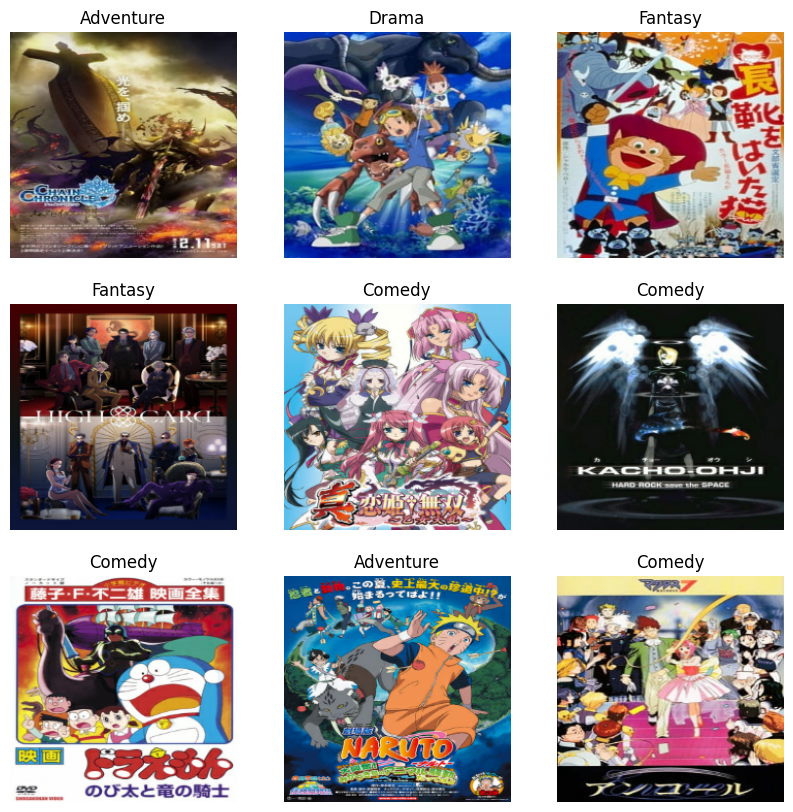

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(h, w, 3)
                          ),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1. / 255),
    layers.Conv2D(16, 3, padding='same', activation='relu',
                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu',
                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu',
                  kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
    layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 20
history = model.fit(
    train_ds,
    batch_size=2000,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.2216 - loss: 3.2529 - val_accuracy: 0.3333 - val_loss: 2.3374
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.1437 - loss: 1.8844 - val_accuracy: 0.2424 - val_loss: 1.5728
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.3419 - loss: 1.6087 - val_accuracy: 0.1818 - val_loss: 1.7291
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.3467 - loss: 1.5977 - val_accuracy: 0.1818 - val_loss: 1.5488
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.3511 - loss: 1.5933 - val_accuracy: 0.2727 - val_loss: 1.4470
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.4391 - loss: 1.5560 - val_accuracy: 0.2424 - val_loss: 1.4548
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.4341 - loss: 1.5344 - val_accuracy: 0.2424 - val_loss: 1.3530
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step - accuracy: 0.4178 - loss: 1.4782 - val_accuracy: 0.2121 - val_loss:

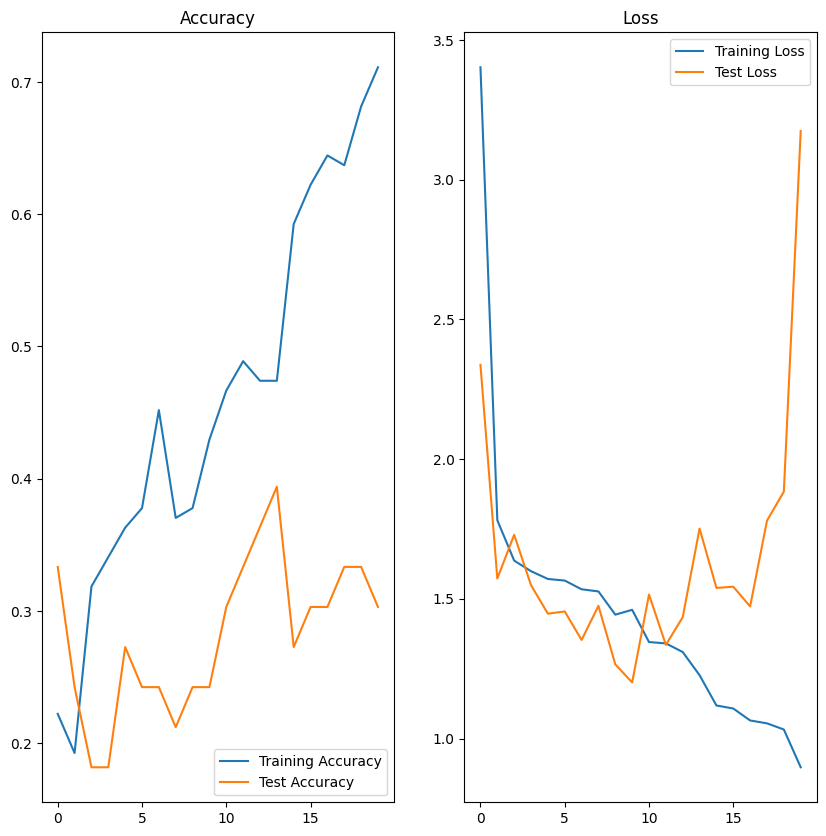

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()